Numpyのみの実装

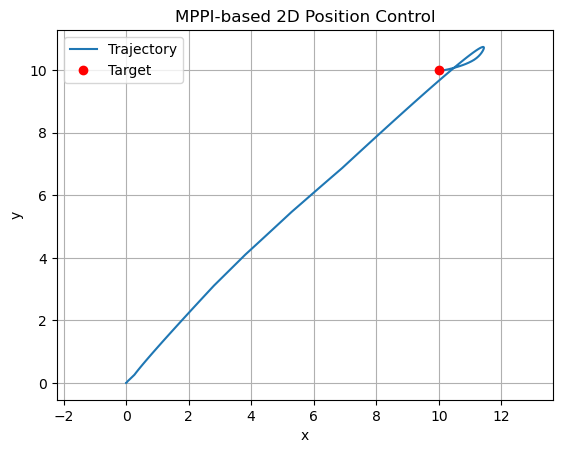

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 設定
dt = 0.1            # 時間刻み
H = 30              # ホライズン
N = 1000            # サンプル数
lambda_ = 1.0       # 温度パラメータ
u_max = 1.0         # 入力制限
target = np.array([10.0, 10.0])  # 目標位置

# 状態: [x, y, vx, vy]
def dynamics(x, u):
    x_new = np.zeros_like(x)
    x_new[0] = x[0] + x[2]*dt
    x_new[1] = x[1] + x[3]*dt
    x_new[2] = x[2] + u[0]*dt
    x_new[3] = x[3] + u[1]*dt
    return x_new

# ステージコスト
def cost_fn(x, u):
    pos_cost = np.linalg.norm(x[:2] - target)**2
    control_cost = 0.1 * np.linalg.norm(u)**2
    return pos_cost + control_cost

# 初期化
x = np.array([0.0, 0.0, 0.0, 0.0])   # 初期状態
u_seq = np.zeros((H, 2))            # 初期制御列

# MPPIループ
trajectory = [x.copy()]
for t in range(100):
    epsilon = np.random.normal(0, 0.5, (N, H, 2))  # ノイズ付き制御列
    costs = np.zeros(N)

    for i in range(N):
        xi = x.copy()
        total_cost = 0.0
        for h in range(H):
            ui = np.clip(u_seq[h] + epsilon[i, h], -u_max, u_max)
            xi = dynamics(xi, ui)
            total_cost += cost_fn(xi, ui)
        costs[i] = total_cost

    # 重み計算
    beta = np.min(costs)
    weights = np.exp(- (costs - beta) / lambda_)
    weights /= np.sum(weights)

    # 制御列更新
    for h in range(H):
        du = np.sum(weights[:, None] * epsilon[:, h], axis=0)
        u_seq[h] += du

    # 一番目の入力適用
    u_apply = np.clip(u_seq[0], -u_max, u_max)
    x = dynamics(x, u_apply)
    trajectory.append(x.copy())

    # 制御列を1ステップ進める
    u_seq[:-1] = u_seq[1:]
    u_seq[-1] = 0.0

# 結果可視化
trajectory = np.array(trajectory)
plt.plot(trajectory[:, 0], trajectory[:, 1], label='Trajectory')
plt.plot(target[0], target[1], 'ro', label='Target')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')
plt.grid()
plt.title('MPPI-based 2D Position Control')
plt.show()


ソフトマックスなし版

In [1]:
import casadi as ca
import numpy as np
import time

# --- 1. システムとMPCのパラメータ定義 ---
nx = 2
nu = 1
N = 10
A = np.array([[1, 1], [0, 1]])
B = np.array([[0.5], [1]])
E = np.array([[0.1], [0.1]])
Q = np.diag([1.0, 0.1])
R = np.diag([0.01])
u_min, u_max = -1.0, 1.0

# --- 2. サンプルベースの設定と高速化対策 ---
M = 25
noise_mean = 0.0
noise_std_dev = 0.2

print(f"予測ホライズン N={N}")
print(f"サンプルシナリオ数 M={M}")

# --- 3. ガウシアンノイズ系列の生成 (修正箇所) ---
# 1次元のベクトル(shape=(N,))としてノイズを生成
np.random.seed(0)
noise_scenarios = [np.random.normal(noise_mean, noise_std_dev, N) for _ in range(M)]

# --- 4. CasADiによる最適化問題の構築 ---
opti = ca.Opti()
U = opti.variable(nu, N)
x0 = opti.parameter(nx, 1)
scenario_costs = []

for m in range(M):
    noise_sequence = noise_scenarios[m]
    X_scenario = opti.variable(nx, N + 1)
    cost_scenario = 0
    opti.subject_to(X_scenario[:, 0] == x0)

    for k in range(N):
        # ★エラー修正: noise_sequence[k] のように1次元でアクセス
        opti.subject_to(X_scenario[:, k+1] == A @ X_scenario[:, k] + B @ U[:, k] + E * noise_sequence[k])
        opti.subject_to(opti.bounded(u_min, U[:, k], u_max))
        cost_scenario += ca.mtimes([X_scenario[:, k].T, Q, X_scenario[:, k]]) + \
                         ca.mtimes([U[:, k].T, R, U[:, k]])
    scenario_costs.append(cost_scenario)

J_vec = ca.vertcat(*scenario_costs)

# --- 5. 目的関数の設定 (高速化対策) ---
# ★対策B: より高速な「平均コスト」を目的関数として使用する
objective = ca.sum1(J_vec) / M
opti.minimize(objective)

# # (参考) もしSoftmax目的関数を使いたい場合は、上の2行をこちらに置き換える
# beta = 1.0
# exp_neg_J = ca.exp(-beta * J_vec)
# weights = exp_neg_J / ca.sum1(exp_neg_J)
# objective_softmax = ca.sum1(weights * J_vec)
# opti.minimize(objective_softmax)


# --- 6. ソルバーの設定と実行 ---
p_opts = {"expand": True}
s_opts = {"print_level": 0}
opti.solver('ipopt', p_opts, s_opts)

current_x = np.array([5.0, 0.0])
opti.set_value(x0, current_x)

try:
    print("\n最適化計算を開始します...")
    start_time = time.time()
    sol = opti.solve()
    end_time = time.time()
    print("最適化成功！")

    #first_u = sol.value(U)[:, 0]
    first_u = sol.value(U)[0]  # 最初の制御入力

    
    print(f"計算時間: {end_time - start_time:.2f} 秒")
    print(f"初期状態: {current_x.flatten()}")
    print(f"適用すべき最初の制御入力 u_0: {first_u}")
    print(f"単純平均コスト (目的関数値): {sol.value(objective):.4f}")

except Exception as e:
    print(f"\n最適化失敗: {e}")

予測ホライズン N=10
サンプルシナリオ数 M=25

最適化計算を開始します...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  46.00us (  3.83us)        12
       nlp_g  |        0 (       0)  65.00us (  5.42us)        12
  nlp_grad_f  |        0 (       0) 101.00us (  7.77us)        13
  nlp_hess_l  |        0 (       0)  29.00us (  2.64us)        11
   nlp_jac_g  |        0 (       0)  85.00us (  6.54us)        13
       total  |  17.00ms ( 17.00ms)  26.79ms ( 26.79ms)         1
最適化成功！
計算時間: 0.03 秒
初期状態: [5. 0.]
適用すべき最初の制御入力 u_0: -1.0000000062874856
単純平均コスト (目的関数値): 56.8739


ソフトマックスで重みづけ

In [ ]:
import casadi as ca
import numpy as np
import time

# --- 1. パラメータ定義 ---
nx = 2
nu = 1
N = 10
A = np.array([[1, 1], [0, 1]])
B = np.array([[0.5], [1]])
E = np.array([[0.1], [0.1]])
Q = np.diag([1.0, 0.1])
R = np.array([[0.01]]) # 2次元配列として定義
u_min, u_max = -1.0, 1.0

# --- 2. サンプルベースの設定 ---
M = 30
noise_mean = 0.0
noise_std_dev = 0.2

print(f"予測ホライズン N={N}")
print(f"サンプルシナリオ数 M={M}")

# --- 3. ノイズ生成 ---
np.random.seed(0)
noise_scenarios = [np.random.normal(noise_mean, noise_std_dev, N) for _ in range(M)]

# --- 4. CasADiによる最適化問題の構築 ---
opti = ca.Opti()
U = opti.variable(nu, N)
x0 = opti.parameter(nx, 1)

# 各シナリオのコストを格納するためのCasADiのシンボリック変数を準備
# ここでvertcatを使うのがエラーを回避するポイント
all_costs = []

for m in range(M):
    noise_sequence = noise_scenarios[m]
    
    # ループ内で変数を定義
    X_scenario = opti.variable(nx, N + 1)
    cost_scenario = 0
    
    # 初期条件
    opti.subject_to(X_scenario[:, 0] == x0)

    for k in range(N):
        # システムダイナミクス
        opti.subject_to(X_scenario[:, k+1] == A @ X_scenario[:, k] + B @ U[:, k] + E * noise_sequence[k])
        # 制約
        opti.subject_to(opti.bounded(u_min, U[:, k], u_max))
        # コスト計算
        cost_scenario += X_scenario[:, k].T @ Q @ X_scenario[:, k] + U[:, k].T @ R @ U[:, k]
                         
    # 計算したコストをリストに追加
    all_costs.append(cost_scenario)

# ループの外で、リスト内の全てのコストを結合して一つのベクトルにする
J_vec = ca.vertcat(*all_costs)


# --- 5. Softmax目的関数の設定 ---
beta = 1.0 
exp_neg_J = ca.exp(-beta * J_vec)
weights = exp_neg_J / ca.sum1(exp_neg_J)
objective = ca.sum1(weights * J_vec)
opti.minimize(objective)


# --- 6. ソルバーの設定と実行 ---
p_opts = {"expand": True}
s_opts = {"print_level": 0}
opti.solver('ipopt', p_opts, s_opts)

current_x = np.array([5.0, 0.0])
opti.set_value(x0, current_x)

try:
    print("\n最適化計算を開始します (Softmax版)...")
    start_time = time.time()
    sol = opti.solve()
    end_time = time.time()
    print("最適化成功！")

    first_u = sol.value(U)[0]  # 最初の制御入力
    
    print(f"計算時間: {end_time - start_time:.2f} 秒")
    print(f"初期状態: {current_x.flatten()}")
    print(f"適用すべき最初の制御入力 u_0: {first_u}")
    print(f"Softmax重み付きコスト (目的関数値): {sol.value(objective):.4f}")

except Exception as e:
    print(f"\n最適化失敗: {e}")

予測ホライズン N=10
サンプルシナリオ数 M=100

最適化計算を開始します (Softmax版)...
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 279.00us ( 18.60us)        15
       nlp_g  |        0 (       0) 407.00us ( 27.13us)        15
  nlp_grad_f  |        0 (       0) 630.00us ( 39.37us)        16
  nlp_hess_l  | 337.00ms ( 24.07ms) 355.19ms ( 25.37ms)        14
   nlp_jac_g  |        0 (       0) 576.00us ( 36.00us)        16
       total  |   7.46 s (  7.46 s)   7.46 s (  7.46 s)         1
最適化成功！
計算時間: 3284.94 秒
初期状態: [5. 0.]
適用すべき最初の制御入力 u_0: -1.0000000044688555
Softmax重み付きコスト (目的関数値): 56.2779
